In [1]:
!jupyter nbconvert --to script Keras_Sentence_RNN.ipynb
import preprocessing


[NbConvertApp] Converting notebook Keras_Sentence_RNN.ipynb to script
[NbConvertApp] Writing 11697 bytes to Keras_Sentence_RNN.py


/home/thongnbui/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
import collections

sentence_max_threshold = 15000
tokenizer, max_sentence_len_word, labels, train_X, test_X, train_y, test_y = preprocessing.get_data(sentence_max_threshold)
print train_X.shape, train_y.shape, len(tokenizer.word_counts)#, len(tokenized_text)

x_count = collections.Counter()
for i in range(len(test_y)):
    x_count.update({str(test_y[i]): 1})

for key, value in sorted(x_count.iteritems(), reverse=True):
    print key, value, float(value)/sentence_max_threshold


Loaded 30 speeches for 2 presidents.
Loaded 1440 speeches for 13 presidents.

How many speeches per president?
0  : Barack Obama         	148
1  : Donald J. Trump      	22
2  : Dwight D. Eisenhower 	192
3  : Franklin D. Roosevelt 	223
4  : George Bush          	97
5  : George W. Bush       	54
6  : Harry S. Truman      	301
7  : Jimmy Carter         	59
8  : John F. Kennedy      	63
9  : Lyndon B. Johnson    	134
10 : Richard Nixon        	39
11 : Ronald Reagan        	46
12 : William J. Clinton   	62

Approximately many words of text per president?
0  : Barack Obama         	858771
1  : Donald J. Trump      	100417
2  : Dwight D. Eisenhower 	569796
3  : Franklin D. Roosevelt 	386250
4  : George Bush          	348692
5  : George W. Bush       	313253
6  : Harry S. Truman      	377745
7  : Jimmy Carter         	224316
8  : John F. Kennedy      	239948
9  : Lyndon B. Johnson    	420226
10 : Richard Nixon        	177240
11 : Ronald Reagan        	178085
12 : William J. Clinton   	319522



### Use Keras_Sentence_RNN.py to avoid time-out problem
If the trained model runs too long, it will time out. To get around this issue, you can skip the run here and instead use Keras_Sentence_RNN.py to train and save the model, then load the saved model here to predict the data.


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, SimpleRNN, Dropout

max_features = len(tokenizer.word_counts) + 1 # + 1 is for padded word id 0s
batch_size = 100

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 100, input_length=max_sentence_len_word))
model.add(SimpleRNN(100,activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adagrad',metrics=['categorical_accuracy'])
print(model.summary())

model.fit(train_X, y=train_y, batch_size=batch_size, nb_epoch=20, verbose=1, class_weight='auto')

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 245, 100)          3597400   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1313      
Total params: 3,618,813
Trainable params: 3,618,813
Non-trainable params: 0
_________________________________________________________________
None


/home/thongnbui/anaconda2/lib/python2.7/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/20
132977/132977 [==============================] - 345s - loss: 2.4901 - categorical_accuracy: 0.1501     

In [4]:
#from keras.models import load_model

# Load the model you trained Keras_Sentence_RNN.py here to predict on test data
#model = load_model('model_40.h5')

In [6]:
import numpy as np
# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)

print "Done prediction."

Evaluating test data...
33216/33245 [============================>.] - ETA: 0s 

Confusion matrix, without normalization
[[1646  143   36   29  205  202   68  119   35   43    3   98  402]
 [ 172  867   21   43   99   79  119   37    8   24    4   30  143]
 [  39   43 1404  170  137   29  365   51  175  148   88  177  171]
 [  69   58  168 1829   80   42  303   54  111  110   20   45  130]
 [ 143   77   84   63 1328  167  163  125   48   84   44  127  515]
 [ 325  119   41   49  380 1480  106  104   30   53   10   47  257]
 [  41   58  182  211  108   30 1830   74   72  219   37   40  134]
 [  84   33   24   21  155   81   83 1147  110   68   84   84  165]
 [  37   18  137   77   93   29  153  178  992  153   94   94  135]
 [  28   50  184  132  138   54  366  156  202 1277  172   61  144]
 [  21    8  120   36   77   24   93  139  144  144  541   47   84]
 [ 111   47  113   35  218   51   87  133   85   45   47  415  394]
 [ 313   95   89   55  506  130  126  151   79   80   30  270 1073]]


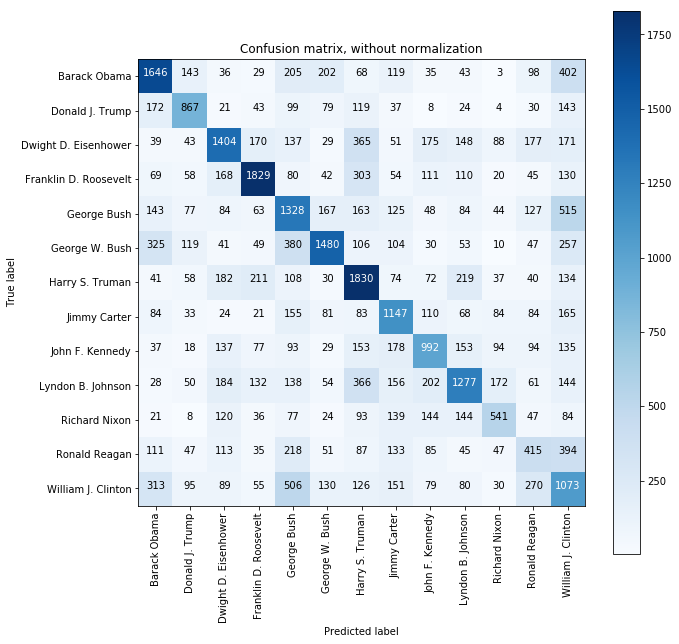

In [7]:
# from scikit-learn examples @
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

# #Plot normalized confusion matrix
# plt.figure(figsize=(10,10))
# plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()